# Active Learning Experiment Notebook

### Import Statements

In [1]:
#Python Library imports
import numpy as np
import torch
import torchvision
from time import time
import random

from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from torch import nn, optim
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms.functional as TF
import torch.nn.functional as F
from torch.autograd import Variable
import os
import glob
import cv2
from tqdm import tqdm

from matplotlib.pyplot import imsave, imread
import matplotlib.pyplot as plt
import sys
import matplotlib.gridspec as gridspec

import copy
import pickle

#Backend py file imports
from floodfill import *
from dataloader import *
from model import *
from oracle import *
from unet import *
import ternausnet.models

In [7]:
import os
import numpy as np

path = "/usr/xtmp/mammo/image_datasets/MedStudentSegmentations_dst/"

all_images = []
for root, dirs, files in os.walk(path):
        for file in files:
            if file.endswith(".xcf"):
                filepath = os.path.join(root, file)
                if("Test" in filepath and "b" in filepath):
                    all_images.append(filepath)
print(len(all_images))
print(all_images[0])
# for image in all_images:
#     print(image)

correction_ids = ["Round/DP_ACSG_19049_1.png",
"Round/DP_ADPE_30241_1.png",
"Round/DP_AIRM_152618_1.png",
"Oval/DP_ABZG_11959_1.png",
"Oval/DP_ACDA_13111_2.png",
"Oval/DP_ADIC_26894_5.png",
"Oval/DP_ADSF_31706_1.png",
"Oval/DP_AEMF_42697_1.png",
"Oval/DP_AENV_44410_1.png",
"Oval/DP_AFOV_68683_1.png",
"Oval/DP_AFRZ_71800_1.png",
"Oval/DP_AFZM_91367_1.png",
"Oval/DP_AGJJ_100839_1.png",
"Oval/DP_AIDV_139678_1.png",
"Oval/DP_AIPU_151146_1.png",
"Oval/DP_AIRL_152601_1.png",
"Irregular/DP_ACYB_21656_1.png",
"Irregular/DP_ADLQ_28579_3.png",
"Irregular/DP_ADOR_30079_1.png",
"Irregular/DP_ADYL_99129_1.png",
"Irregular/DP_ADZH_35370_1.png",
"Irregular/DP_AEAF_35761_1.png",
"Irregular/DP_AEAI_35811_1.png",
"Irregular/DP_AFCF_56907_1.png",
"Irregular/DP_AISN_153460_1.png",
"Irregular/DP_AJPZ_198114_1.png",
"Irregular/DP_AJQW_80316_1.png",
"Irregular/DP_AJTT_82938_1.png",
"Irregular/DP_AKAY_89024_1.png",
"Irregular/DP_AKDA_1987_1.png",
"Irregular/DP_AKSS_15443_1.png",
"Irregular/DP_AKSS_15444_1.png"]

correction_filepaths = []
#Irregular/DP_ADOR_30079_1_fa.png
for correction in correction_ids:
    new_correction = correction[:-4]+"_fa.xcf"
    #print(new_correction)
    found = False
    for image in all_images:
        if new_correction in image:
            correction_filepaths.append(image)
            found = True
    if not found:
        print(new_correction)

print(len(correction_filepaths))            
print("done")
commands = []
for filepath in correction_filepaths:
    command = "cp " + filepath + " /usr/xtmp/mammo/image_datasets/MedStudentCorrections/TestB/"
    commands.append(command)
print(len(correction_filepaths))
for command in commands:
    print(command)

169
/usr/xtmp/mammo/image_datasets/MedStudentSegmentations_dst/TestBatch_10b/Round/DP_ADPE_30241_1_fa.xcf
32
done
32
cp /usr/xtmp/mammo/image_datasets/MedStudentSegmentations_dst/TestBatch_11b/Round/DP_ACSG_19049_1_fa.xcf /usr/xtmp/mammo/image_datasets/MedStudentCorrections/TestB/
cp /usr/xtmp/mammo/image_datasets/MedStudentSegmentations_dst/TestBatch_10b/Round/DP_ADPE_30241_1_fa.xcf /usr/xtmp/mammo/image_datasets/MedStudentCorrections/TestB/
cp /usr/xtmp/mammo/image_datasets/MedStudentSegmentations_dst/TestBatch_3b/Round/DP_AIRM_152618_1_fa.xcf /usr/xtmp/mammo/image_datasets/MedStudentCorrections/TestB/
cp /usr/xtmp/mammo/image_datasets/MedStudentSegmentations_dst/TestBatch_6b/Oval/DP_ABZG_11959_1_fa.xcf /usr/xtmp/mammo/image_datasets/MedStudentCorrections/TestB/
cp /usr/xtmp/mammo/image_datasets/MedStudentSegmentations_dst/TestBatch_9b/Oval/DP_ACDA_13111_2_fa.xcf /usr/xtmp/mammo/image_datasets/MedStudentCorrections/TestB/
cp /usr/xtmp/mammo/image_datasets/MedStudentSegmentations_dst/

### Run ID Setup

#run_id has format of "mm_dd_count", where count is the current run on the day (a,b,etc)
run_id = "07_19_a" 

In [ ]:
#users_name tells us who is working on the notebook (vaibhav/alina)
users_name = input("what is your name: ")
print(f"Your name is: {users_name}.")

## Active Learning Stage

### Initialization

In [ ]:
im_dir = "" #im_dir is the directory where oracle pulls images

In [ ]:
dataloader = get_DataLoader(im_dir,32,2) #Generates dataloader from im_dir. Takes in batch_size and num_workers

#Initializes oracle results dict and thresholds dict
oracle_results = {}
oracle_results_thresholds = {}

### Initial Training

In [ ]:
model,loss_tracker,criterion,optimizer = initialize_and_train_model(dataloader, epochs=5) #default batch_size and epochs
plt.plot(loss_tracker) #plot graph

In [ ]:
#Gets the patient scores based on initial trained model. Patient scores is how "good" the model thinks the segmentation is
all_patient_scores = []

patient_scores = get_patient_scores(model,dataloader)  #patient_scores is a dictionary of patient->score
all_patient_scores.append(patient_scores)

### Oracle Querying

In [ ]:
#Queries the oracle. Relevant arguments: query_method and query_number
#Query methods: best, worst, percentile=0.x, uniform.
#Put 1 if correct, 0 if impossible, new threshold if new threshold will help.

new_oracle_results, new_oracle_results_thresholds = query_oracle(oracle_results,oracle_results_thresholds,
                                                                 patient_scores,im_dir,query_method="best",
                                                                 query_number=13)
oracle_results, oracle_results_thresholds = new_oracle_results, new_oracle_results_thresholds

### Updating

In [ ]:
#Update patient scores and add to all_patient_scores array
patient_scores = get_patient_scores(model,dataloader)
all_patient_scores.append(patient_scores)

In [ ]:
#Update the active learning classifier with learned data
#TODO: track model loss somehow along with patient_scores (KEEP TODO AND ADDRESS)
for i in range(3):
    model = model_update(model,dataloader,oracle_results,criterion,optimizer,num_epochs=1)

    patient_scores = get_patient_scores(model,dataloader)
    all_patient_scores.append(patient_scores)

**Go Back to Oracle Querying Heading if you want to keep querying images**

### Plotting Active Learning Metrics

In [ ]:
#Prints out metrics for all the patient scores from each update.
for i in all_patient_scores:
    print(calculate_dispersion_metric(i,oracle_results))

In [ ]:
#Plot the disperson metric
j = []
for i in all_patient_scores:
    j.append(calculate_dispersion_metric(i,oracle_results))
    
plt.plot(j)

In [ ]:
print("Length of patient scores: " + str(len(patient_scores)))
print("Length of oracle results: " + str(len(oracle_results)))

scores = []
for key in patient_scores.keys():
    scores.append(patient_scores[key])
plt.plot(scores)

ones = 0
for i in oracle_results.keys():
    if oracle_results[i]==1:
        ones+=1
print("Number of ones in oracle results: ", ones)

In [58]:
im_dir = "/usr/xtmp/vs196/mammoproj/Data/manualfa/train/" #manually labelled training segmentations
manual_fa_train_dir = "/usr/xtmp/vs196/mammoproj/Data/manualfa/train/"
model_save_dir = "/usr/xtmp/vs196/mammoproj/Code/SavedModels/ControlALUNet/0726/"

if not os.path.exists(model_save_dir):
    os.makedirs(model_save_dir)

In [59]:
sizes = []
metrics = []

In [2]:
def from_manual_segmentation_dataloader_with_size(manual_seg_dir,batch_size,num_workers,size):
    filepaths = []
    for root,dirs,files in os.walk(manual_seg_dir):
        for file in files:
            if file.endswith(".npy"):
                filepaths.append(os.path.join(root,file))
    filepaths=  filepaths[:size]
    new_unet_dataloader = unet_dataloader(filepaths,batch_size,num_workers)
    return new_unet_dataloader


def intersection_over_union(output_mask,ground_mask):
    ground_mask = get_ints(ground_mask).squeeze(1)
    summed = ground_mask + output_mask
    twos = summed - 2
    num = 256*256 - torch.count_nonzero(twos)
    denom = torch.count_nonzero(summed)
    outputs = torch.div(num,denom)
    return torch.mean(outputs)

def evaluate_metric_on_validation(model,validation_dir):
    model.eval()
    transforms_arr = [transforms.ToTensor(),transforms.Resize((256,256))]
    image_transform = transforms.Compose(transforms_arr)
    ious = []
    segmentation_filepaths = []

    for root, dirs, files in os.walk(validation_dir):
        for file in files:
            if file.endswith(".npy"):
                segmentation_filepaths.append(os.path.join(root,file))
    
    for filepath in tqdm(segmentation_filepaths):
        arr_and_bin_output = np.load(filepath)

        arr = arr_and_bin_output[0,:,:].copy()
        bin_output = arr_and_bin_output[1,:,:].copy()

        mask = image_transform(bin_output)[0,:,:]
        arr = exposure.equalize_hist(arr) #add hist equalization to 
        image = image_transform(arr)        
        
        image = image.float()
        image = convert_to_3channel(image).cuda()
        image = transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)) (image)

        unet_seg = model(image)
        unbinarized_unet_seg = F.softmax(unet_seg[0],dim=0)[1,:,:]
        unet_seg = get_binary_mask(unbinarized_unet_seg).cpu()
        iou = intersection_over_union(unet_seg,mask)
        ious.append(iou)
    return np.average(np.asarray(ious))

In [64]:
for size in range(10,200,10):
    #initialize dataloader and model
    manual_fa_dataloader = from_manual_segmentation_dataloader_with_size(manual_fa_train_dir,10,2,size)
    unet_model = getattr(ternausnet.models, "UNet16")(num_classes=2,pretrained=True).cuda()

    #train model
    unet_model,loss_tracker,metric_tracker = unet_update_model(unet_model,manual_fa_dataloader,num_epochs=10)

    #save model
    #model_save_path = model_save_dir + f"unetmodel_size{size}.pth"
    #torch.save(unet_model,model_save_path)

    manual_fa_valid_dir = f"/usr/xtmp/vs196/mammoproj/Data/manualfa/manual_validation/"
    metric = evaluate_metric_on_validation(unet_model,manual_fa_valid_dir)
    sizes.append(size)
    metrics.append(metric)
    print(f"Done with size={size}. Metric={metric}")
    break
print("Done with all sizes")

100%|██████████| 116/116 [00:02<00:00, 55.64it/s]

Done with size=10. Metric=0.3384363651275635
Done with all sizes


In [2]:
def get_ints_np(mask):
    return torch.where(mask>0.2,1,0)

def get_binary_mask_threshold_np(mask,threshold):
    return torch.where(mask > threshold, 1, 0)


def intersection_over_union_np(output_mask,ground_mask):
    ground_mask = get_ints_np(ground_mask)
    summed = ground_mask + output_mask
    twos = summed - 2
    num = 256*256 - np.count_nonzero(twos)
    denom = torch.count_nonzero(summed)
    outputs = torch.div(num,denom)
    return torch.mean(outputs)

#TODO: Check if patID has shape subdir. If not, you're going to have to find them manually.
def calculate_iou(patID,threshold,ground_truth_dir,segmentation_dir):
    ground_truth_path = ground_truth_dir + patID + ".npy"
    segmentation_path = segmentation_dir + patID + ".npy"

    ground_truth = np.load(ground_truth_path)[1,:,:]
    segmentation = np.load(segmentation_path)[1,:,:]
    
    transforms_arr = [transforms.ToTensor(),transforms.Resize((256,256))]
    image_transform = transforms.Compose(transforms_arr)
    
    ground_truth = image_transform(ground_truth)[0,:,:]
    segmentation = image_transform(segmentation)[0,:,:]
    
    binarized = get_binary_mask_threshold_np(segmentation,threshold)
    return intersection_over_union_np(binarized,ground_truth)

#Mimics same input/output as ask_oracle from oracle.py. 
#Only difference is that it asks for two directories as it needs both the unbinarized seg dir and the ground truth dir
def ask_oracle_automatic(oracle_results, oracle_results_thresholds,oracle_queries, ground_truth_dir,segmentation_dir, iou_threshold=0.9):
    for patID in oracle_queries:
        max_iou = -1
        max_threshold = 0
        #calculate iou over a variety of thresholds
        thresholds = [0.01,0.05,0.1,0.15,0.2]
        for threshold in thresholds:
            iou = calculate_iou(patID,threshold,ground_truth_dir,segmentation_dir)
            #Check if proposed segmentation is very close to ground truth (Starting off at 0.2)
            if iou > max_iou:
                max_iou = iou
                max_threshold = threshold
        if(max_iou > iou_threshold):
            #return a 1 with correct threshold
            oracle_results[patID] = 1
        else:
            oracle_results[patID] = 0
        oracle_results_thresholds[patID] = max_threshold #Regardless of the correctness of segmentation, we assign the threshold which gives the highest IOU.
    return oracle_results,oracle_results_thresholds


def query_oracle_automatic(oracle_results,oracle_results_thresholds,patient_scores,ground_truth_dir,segmentation_dir,query_method="uniform",query_number=10):
    if query_number==0:
        print("Why are you asking for 0 queries?")
        return oracle_results
    if query_number>len(patient_scores):
        print("Query too big for number of patients")
        return oracle_results
    oracle_queries = []
    if query_method=="uniform":
        step = len(patient_scores)//(query_number-1)
        for i in range(0,len(patient_scores),step):
            if list(patient_scores.keys())[i] not in list(oracle_results.keys()):
                oracle_queries.append(list(patient_scores.keys())[i])
    elif query_method=="random":
        indices = random.sample(len(patient_scores), query_number)
        for i in indices:
            if list(patient_scores.keys())[i] not in list(oracle_results.keys()):
                oracle_queries.append(list(patient_scores.keys())[i])
    elif query_method=="best":
         for i in range(query_number-1,-1,-1):
                if list(patient_scores.keys())[i] not in list(oracle_results.keys()):
                    oracle_queries.append(list(patient_scores.keys())[i])
    elif query_method=="worst":
        for i in range(query_number):
            if list(patient_scores.keys())[i] not in list(oracle_results.keys()):
                oracle_queries.append(list(patient_scores.keys())[i])
    elif 'middle' in query_method:
        #find the number of elements closest to 0.5
        split_val = float(query_method.split('=')[-1])
        middle_index = int(len(patient_scores.keys())/(1/split_val))
        left_bound = 0 if middle_index - int(query_number/2) < 0 else middle_index - int(query_number/2)
        indices = list(range(middle_index,middle_index+int(query_number/2))) + range(left_bound,middle_index)
        for i in indices:
            if list(patient_scores.keys())[i] not in list(oracle_results.keys()):
                oracle_queries.append(list(patient_scores.keys())[i])
        print("Debugging for middle index: "  + str(middle_index) + " " + str(patient_scores[middle_index]))
    elif "percentile" in query_method:
        percentile = float(query_method.split('=')[-1])
        near_index = int(len(patient_scores.keys()) * percentile)
        indices = list(range(near_index - int(query_number/2), near_index)) + list(range(near_index, near_index + int(query_number/2)))
        for i in indices:
            if list(patient_scores.keys())[i] not in list(oracle_results.keys()):
                oracle_queries.append(list(patient_scores.keys())[i])
    else:
        print("You entered an unsupported query method.")
        return oracle_results,oracle_results_thresholds

    oracle_results, oracle_results_thresholds = ask_oracle_automatic(oracle_results,oracle_results_thresholds,oracle_queries,ground_truth_dir,segmentation_dir)
    
    return oracle_results, oracle_results_thresholds

In [7]:
#Python Library imports
import numpy as np
import torch
import torchvision
from time import time
import random

from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from torch import nn, optim
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms.functional as TF
import torch.nn.functional as F
from torch.autograd import Variable
import os
import glob
import cv2
from tqdm import tqdm

from matplotlib.pyplot import imsave, imread
import matplotlib.pyplot as plt
import sys
import matplotlib.gridspec as gridspec

import copy
import pickle
import argparse

#Backend py file imports
from floodfill import *
from dataloader import *
from model import *
from oracle import *
from unet import *
#from manual_oracle import query_oracle_automatic,ask_oracle_automatic

#grab arguments from command line
# parser = argparse.ArgumentParser()
# parser.add_argument("--random_seed", type=int)
# args = parser.parse_args()
# random_seed_number = args.random_seed

# random_seed_number = 1

# #set random seeds
# torch.manual_seed(random_seed_number)
# torch.cuda.manual_seed(random_seed_number)
# np.random.seed(random_seed_number)
# random.seed(random_seed_number)
# torch.backends.cudnn.enabled=False
# torch.backends.cudnn.deterministic=True


#write a custom dataloader that only uses x images from the training dataset
#size is the number of datapoints we're using in the dataloader
def from_manual_segmentation_dataloader_with_size(manual_seg_dir,batch_size,num_workers,size):
    filepaths = []
    for root,dirs,files in os.walk(manual_seg_dir):
        for file in files:
            if file.endswith(".npy"):
                filepaths.append(os.path.join(root,file))
    #sort by patient id
    filepaths = sorted(filepaths, key=lambda x:x.split("/")[-1])
    filepaths = filepaths[0:size]
    new_unet_dataloader = unet_dataloader(filepaths,batch_size,num_workers)
    return new_unet_dataloader


def intersection_over_union(output_mask,ground_mask):
    ground_mask = get_ints(ground_mask).squeeze(1)
    summed = ground_mask + output_mask
    twos = summed - 2
    num = 256*256 - torch.count_nonzero(twos)
    denom = torch.count_nonzero(summed)
    outputs = torch.div(num,denom)
    return torch.mean(outputs)

def evaluate_metric_on_validation(model,validation_dir):
    model.eval()
    transforms_arr = [transforms.ToTensor(),transforms.Resize((256,256))]
    image_transform = transforms.Compose(transforms_arr)
    ious = []
    segmentation_filepaths = []

    for root, dirs, files in os.walk(validation_dir):
        for file in files:
            if file.endswith(".npy"):
                segmentation_filepaths.append(os.path.join(root,file))
    
    for filepath in tqdm(segmentation_filepaths):
        arr_and_bin_output = np.load(filepath)

        arr = arr_and_bin_output[0,:,:].copy()
        bin_output = arr_and_bin_output[1,:,:].copy()

        mask = image_transform(bin_output)[0,:,:]
        arr = exposure.equalize_hist(arr) #add hist equalization to 
        image = image_transform(arr)        
        
        image = image.float()
        image = convert_to_3channel(image).cuda()
        image = transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)) (image)

        unet_seg = model(image)
        unbinarized_unet_seg = F.softmax(unet_seg[0],dim=0)[1,:,:]
        unet_seg = get_binary_mask(unbinarized_unet_seg).cpu()
        iou = intersection_over_union(unet_seg,mask)
        ious.append(iou)
    return np.average(np.asarray(ious))


#Returns the original image, ground truth label, binarized UNet segmentation output, and iou of the ground truth and binarized seg output.
#Takes in the image filepath and the model for segmenting.
def grab_iou_of_image(image_filepath,model):
    model.eval()
    transforms_arr = [transforms.ToTensor(),transforms.Resize((256,256))]
    image_transform = transforms.Compose(transforms_arr)

    arr_and_bin_output = np.load(image_filepath)

    arr = arr_and_bin_output[0,:,:].copy()
    bin_output = arr_and_bin_output[1,:,:].copy()

    mask = image_transform(bin_output)[0,:,:]
    arr = exposure.equalize_hist(arr) #add hist equalization to 
    image = image_transform(arr)        
    
    image = image.float()
    image = convert_to_3channel(image).cuda()
    image = transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)) (image)

    unet_seg = model(image)
    unbinarized_unet_seg = F.softmax(unet_seg[0],dim=0)[1,:,:]
    unet_seg = get_binary_mask(unbinarized_unet_seg).cpu()
    iou = intersection_over_union(unet_seg,mask)
    return image,mask,unet_seg,iou

def control_run():
    #Initialize filepaths 
    im_dir = "/usr/xtmp/vs196/mammoproj/Data/manualfa/train/" #manually labelled training segmentations
    manual_fa_train_dir = "/usr/xtmp/vs196/mammoproj/Data/manualfa/train/"
    model_save_dir = "/usr/xtmp/vs196/mammoproj/Code/SavedModels/ControlALUNet/0726/"
    if not os.path.exists(model_save_dir):
        os.makedirs(model_save_dir)
    sizes = []
    metrics = []
    for size in range(10,200,10):
        #initialize dataloader and model
        manual_fa_dataloader = from_manual_segmentation_dataloader_with_size(manual_fa_train_dir,10,2,size)
        unet_model = getattr(ternausnet.models, "UNet16")(num_classes=2,pretrained=True).cuda()

        #train model
        unet_model,loss_tracker,metric_tracker = unet_update_model(unet_model,manual_fa_dataloader,num_epochs=25)

        #save model
        model_save_path = model_save_dir + f"unetmodel_size{size}.pth"
        torch.save(unet_model,model_save_path)

        manual_fa_valid_dir = f"/usr/xtmp/vs196/mammoproj/Data/manualfa/manual_validation/"
        metric = evaluate_metric_on_validation(unet_model,manual_fa_valid_dir)
        sizes.append(size)
        metrics.append(metric)
        print(f"Done with size={size}. Metric={metric}")
    print("Done with all sizes")
    plt.scatter(sizes,metrics)
    sizes_np = np.asarray(sizes)
    metrics_np = np.asarray(metrics)
    data_save_dir = "/usr/xtmp/vs196/mammoproj/Code/ActiveLearning/0727controlrun/"
    if not os.path.exists(data_save_dir):
        os.makedirs(data_save_dir)
    sizes_save_path = "/usr/xtmp/vs196/mammoproj/Code/ActiveLearning/0727controlrun/sizes.npy"
    metrics_save_path = "/usr/xtmp/vs196/mammoproj/Code/ActiveLearning/0727controlrun/metrics.npy"
    np.save(sizes_save_path,sizes_np)
    np.save(metrics_save_path,metrics_np)
    plt.savefig("/usr/xtmp/vs196/mammoproj/Code/ActiveLearning/0727controlrun/control_graph.png")
    print("Done")


# if __name__ == "__main__":
#     model_save_path = "/usr/xtmp/vs196/mammoproj/Code/SavedModels/ControlALUNet/0726/unetmodel_size150.pth"
#     model = torch.load(model_save_path)
#     image_filepath = "/usr/xtmp/vs196/mammoproj/Data/manualfa/manual_validation/Round/DP_AAZA_161134.npy"
#     image,mask,unet_seg,iou = grab_iou_of_image(image_filepath,model)
#     print(f"IOU of this image is: {iou}")


#Evaluates BINARIZED segmentations from a eval_dir containing image and manual segmentation.
#Saves as [image,segmentation] np stack in save_dir.
#DID NOT NEED THIS CODE
def generate_segmentations(model,manual_seg_dir,save_dir):
    image_transform = None #FIX
    images_filepaths = []
    for root, dirs, files in os.walk(manual_seg_dir):
            for file in files:
                if file.endswith(".npy"):
                    images_filepaths.append(os.path.join(root,file))
        
    for image_filepath in tqdm(images_filepaths):
        #Load image from filepath
        image_and_manual_seg = np.load(image_filepath)
        arr = image_and_manual_seg[0,:,:].copy()
        loaded_image = arr.copy()
        
        #Preprocess image before feeding to model
        arr = exposure.equalize_hist(arr) #add hist equalization
        image = image_transform(arr)        
        image = image.float()
        image = convert_to_3channel(image).cuda()
        image = transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)) (image)

        #Evaluate unbinarized unet seg
        unet_seg = model(image)
        unbinarized_unet_seg = F.softmax(unet_seg[0],dim=0)[1,:,:]

        #Save to save_dir.
        patID = '/'.join(image_filepath.split("/")[-2:])[:-4]
        image_save_path = save_dir + patID + ".npy"
        print(image_save_path)
        break
        #np.save(image_save_path,np.stack([loaded_image,unbinarized_unet_seg]))
    print(f"Saved unbinarized segmentations of {len(images_filepaths)} images to {save_dir}.")

#One run to generate unbinarized training segmentations from scratch.
#generate_segmentations(model,classifier_training_dir,"/usr/xtmp/vs196/mammoproj/Data/manualfa/unbinarized_train_seg/")

def plot_active_learning_training_metrics(all_patient_scores,oracle_results):
    pass

#Saves any correct segmentations found by the oracle, and additionally pickle dumps any structures 
def save_active_learning_results(run_id,iter_num,oracle_results,oracle_results_thresholds,im_dir):
    save_dir = "/usr/xtmp/vs196/mammoproj/Code/ActiveLearning/AllOracleRuns/Run_" + run_id + "/Iter" + str(iter_num)
    correct_segs_save_dir = save_dir + "CorrectSegmentations/"

    saved_oracle_filepaths = save_oracle_results(oracle_results,oracle_results_thresholds,im_dir,correct_segs_save_dir)
    fpath = save_dir + "saved_data_struct/"
    if not os.path.exists(fpath):
        os.makedirs(fpath)
    saved_oracle_filepaths_filepath = save_dir + "saved_data_struct/Oracle_Filepaths.pickle"
    pickle.dump(saved_oracle_filepaths,open(saved_oracle_filepaths_filepath,"wb"))
    pickle.dump(oracle_results,open(save_dir + "saved_data_struct/Oracle_Results.pickle","wb"))
    pickle.dump(oracle_results_thresholds,open(save_dir + "saved_data_struct/Oracle_Results_Thresholds.pickle","wb"))

    return saved_oracle_filepaths


def update_dir_with_oracle_info(run_id,iter_num,oracle_results_thresholds,im_dir):
    save_dir = "/usr/xtmp/vs196/mammoproj/Code/ActiveLearning/AllOracleRuns/Run_" + run_id + "/Iter" + str(iter_num) + "/OracleThresholdedImages/"
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    #find all filepaths in im_dir
    all_filepaths = []
    for root, dirs, files in os.walk(im_dir):
        for file in files:
            if file.endswith(".npy"):
                all_filepaths.append(os.path.join(root, file))

    threshold_and_save_images(all_filepaths, oracle_results_thresholds, save_dir)
    save_dir = convert_directory_to_floodfill(save_dir,iter0=False)
    return save_dir

def redirect_saved_oracle_filepaths_to_thresheld_directory(saved_oracle_filepaths,im_dir):
    new_filepaths = [(im_dir + "/".join(filepath.split("/")[-2:])) for filepath in saved_oracle_filepaths]
    return new_filepaths
    

def active_learning_experiment(active_learning_train_cycles,query_cycles,query_number,unet_model,run_id,iter_num):
    #ACTIVE LEARNING STAGE
    #File definitions and static setup
    classifier_training_dir = "/usr/xtmp/vs196/mammoproj/Data/manualfa/train/"
    ground_truth_dir = "/usr/xtmp/vs196/mammoproj/Data/manualfa/train/"
    segmentation_dir = "/usr/xtmp/mammo/image_datasets/data_split_july2021/square_ROI_by_shape_segmentations_unbin/train/" #Unbinarized train segmentations from something idk.
    oracle_results = dict()
    oracle_results_thresholds = dict()
    total_images_shown = 0
    saved_oracle_filepaths = []

    #Begin loop over number of active learning/
    for active_learning_cycle in range(active_learning_train_cycles):
        #Variable Definitions
        dataloader = get_DataLoader(classifier_training_dir,32,2)
        model,loss_tracker,criterion,optimizer = initialize_and_train_model_experiment(dataloader, epochs=1) #Initialize and train classifier for 10 epochs.  #TODO:rewrite dataloader to use all positive segmentations from manual classifier (NOT switching)
        patient_scores = get_patient_scores(model,dataloader)
        all_patient_scores = []

        #Querying oracle - currently queries {query_cycles} times.
        for query_iter in range(query_cycles):
            oracle_results, oracle_results_thresholds = query_oracle_automatic(oracle_results,oracle_results_thresholds,patient_scores,ground_truth_dir,segmentation_dir,query_method="uniform",query_number=query_number)
            total_images_shown += query_number

        #Updating classifier 1 epoch at a time for 5 epochs. 
        for i in range(5):
            model = model_update(model,dataloader,oracle_results,criterion,optimizer,num_epochs=1)

            patient_scores = get_patient_scores(model,dataloader)
            all_patient_scores.append(patient_scores)

        #Space for plotting metrics if you want.
        plot_active_learning_training_metrics(all_patient_scores,oracle_results)

        print("Done with one iteration of active learning querying/updating")
    print(total_images_shown)

    #IN-BETWEEN STAGE
    #Space for saving oracle results and pickling data structures
    saved_oracle_filepaths = save_active_learning_results(run_id,iter_num,oracle_results,oracle_results_thresholds,classifier_training_dir)
    oracle_results = remove_bad_oracle_results(oracle_results) #not necessary as oracle_results is never even used again in this method.
    if len(saved_oracle_filepaths)==0:
        print("No correct oracle results")
        return 0
#     #SEGMENTATION STAGE
    #Preprocess data with information learned from active learning.
    unet_train_dir = update_dir_with_oracle_info(run_id,iter_num,oracle_results_thresholds,segmentation_dir)
    new_saved_oracle_filepaths = redirect_saved_oracle_filepaths_to_thresheld_directory(saved_oracle_filepaths, unet_train_dir)
    print(len(new_saved_oracle_filepaths))
    unetdataloader = unet_dataloader(new_saved_oracle_filepaths,8,2)
    loss_tracker = []
    metric_tracker = []

    #Train model using learned oracle data for 10 epochs
    unet_model,loss_tracker,metric_tracker = unet_update_model(unet_model,unetdataloader,num_epochs=10)

    #evaluation 1: generate new segmentations of training images and save them. (This is for the next stage of active learning)
    segmentation_folder = segmentation_dir
    correct_save_dir = "/usr/xtmp/vs196/mammoproj/Code/ActiveLearning/AllOracleRuns/Run_" + run_id + "/Iter" + str(iter_num) + "/UNetSegmentations_C/"
    save_dir = "/usr/xtmp/vs196/mammoproj/Code/ActiveLearning/AllOracleRuns/Run_" + run_id + "/Iter" + str(iter_num) + "/UNetSegmentations/"
    evaluate_model_on_new_segmentations_and_save(unet_model,segmentation_folder,saved_oracle_filepaths,correct_save_dir,save_dir,iter_num)
    #next_iter_segmentation_dir = convert_directory_to_floodfill(save_dir,iter0=False) #WE SHOULDN'T NEED THIS BECAUSE WE ARE SAVING UNBINARIZED OUTPUT
    #push next_iter_segmentation_dir as the oracle image dir for next iteration. NVM look below
    #Push save_dir as the oracle image dir for the next iteration. That's where we populate with unbinarized segmentations from recently trained UNet

    #evaluation 2: generate segmentations of validation and see how accurate our new segmenter is
    manual_fa_valid_dir = f"/usr/xtmp/vs196/mammoproj/Data/manualfa/manual_validation/"
    metric = evaluate_metric_on_validation(unet_model,manual_fa_valid_dir)
    print(f"Metric of new segmenter after active learning is: {metric}.")

    #potentially save model this iteration if we want.
    model_save_path = "/usr/xtmp/vs196/mammoproj/Code/ActiveLearning/AllOracleRuns/Run_" + run_id + "/Iter" + str(iter_num) + "/unetmodel.pth"
    torch.save(unet_model,model_save_path)

    return metric

#Outline of experiment:
#loop over:
#   Active Learning Stage
#   Segmentation Stage
#   Evaluation Stage + Metrics
model_save_path = "/usr/xtmp/vs196/mammoproj/Code/SavedModels/ControlALUNet/0726/unetmodel_size150.pth"
unet_model = torch.load(model_save_path)
metric = active_learning_experiment(3,5,20,unet_model,"08_03jupyter",1)
print(metric)


Using cache found in /home/users/vs196/.cache/torch/hub/pytorch_vision_v0.10.0
100%|██████████| 18/18 [00:05<00:00,  3.14it/s]
Using cache found in /home/users/vs196/.cache/torch/hub/pytorch_vision_v0.10.0


Done with one iteration of active learning querying/updating


100%|██████████| 18/18 [00:05<00:00,  3.40it/s]
Using cache found in /home/users/vs196/.cache/torch/hub/pytorch_vision_v0.10.0


Done with one iteration of active learning querying/updating


100%|██████████| 18/18 [00:05<00:00,  3.14it/s]

Done with one iteration of active learning querying/updating
300
Done with saving this iteration of oracle results
No correct oracle results
0


In [4]:
print(total_images_shwon)

20


In [3]:
def unet_update_model_notebook(model,inhouse_dataloader,num_epochs=10,has_weights=True,weight_ratio=0.5):    
    criterion = weightedpixelcros
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    #optimizer = torch.optim.SGD(model.parameters(),lr=0.001,momentum=0.9)
    loss_tracker = [] #plot loss
    metric_tracker = []

    model.train()
    #training loop
    for epoch in range(num_epochs):
        tr_loss = 0.0
        count = 0
        metric = 0.0
        print("in1")
        for grouped in tqdm(inhouse_dataloader):
            #print("in2")
            #push to cuda
            images = grouped[0]
            images = images.float()
            labels = grouped[1]
            if has_weights:
                weights = get_weight(grouped[2],weight_ratio=weight_ratio)
                weights = weights.cuda()
            #print(images.shape)
            #images = transforms.Normalize(mean=(0.445,), std=(0.269,))(images) #normalize
            images = convert_to_3channel(images).cuda()
            #Include bottom line (normalize after convert to 3-channels)
            images = transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)) (images)
            #images = convert_to_3channel(images).cuda() if not pet_flag else images.cuda()
            #print(images.shape)
            #labels = labels.long()
            #labels = labels.squeeze(1)
            labels = labels.cuda()
            optimizer.zero_grad()
            #print("IMAGE SHAPE: ")
            #print(images.shape)
            y = model(images)
            #y = y.squeeze(1)
            #y = y.cuda()
            if has_weights:
                loss = criterion(y,labels,weights)
            else:
                loss = criterion(y,labels)
            loss.backward()
            optimizer.step()
            tr_loss += loss.detach().cpu().item()
            count += images.shape[0]
            metric += intersection_over_union(y,labels)*images.shape[0]
            #print(images.shape[0])
            #print(images.shape)
            #print(labels.shape)
            #print(weights.shape)
            #break
        loss_tracker.append(tr_loss/(count))
        metric_tracker.append(metric/count)
    return model,loss_tracker,metric_tracker

0.034020532
0.89879006
0.6226698
0.70213956


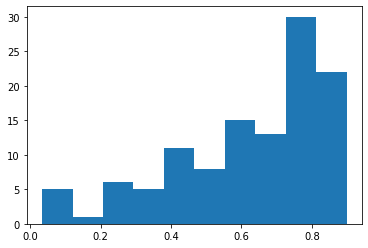

115


In [38]:
iou_arr = np.load("/usr/xtmp/vs196/mammoproj/Code/ActiveLearning/iouhist_1.npy")
print(np.min(iou_arr))
print(np.max(iou_arr))
print(np.mean(iou_arr))
print(np.median(iou_arr))
iou_arr_aslist = iou_arr.tolist()
plt.hist(iou_arr_aslist)
plt.show()
print(np.count_nonzero(np.where(iou_arr>-1)))

In [12]:
validation_dir = "/usr/xtmp/vs196/mammoproj/Data/manualfa/manual_validation/"
segmentation_filepaths = []
for root, dirs, files in os.walk(validation_dir):
        for file in files:
            if file.endswith(".npy"):
                segmentation_filepaths.append(os.path.join(root,file))
print(len(segmentation_filepaths))

116


In [13]:
print(len(iou_arrx))

116


(256, 256)
(256, 256)
tensor(0.0577)


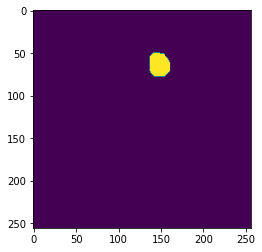

In [2]:
def intersection_over_union_exp(output_mask,ground_mask):
    ground_mask = get_ints(ground_mask).squeeze(1)
    summed = ground_mask + output_mask
    twos = summed - 2
    num = 256*256 - torch.count_nonzero(twos)
    denom = torch.count_nonzero(summed)
    outputs = torch.div(num,denom)
    return torch.mean(outputs)


import numpy as np
path = "/usr/xtmp/vs196/mammoproj/Code/ActiveLearning/iou_test_images/bad/DP_AACA_162_1.npy"
path = "/usr/xtmp/vs196/mammoproj/Code/ActiveLearning/iou_test_images/bad/DP_AASB_7172_1.npy"
path = "/usr/xtmp/vs196/mammoproj/Code/ActiveLearning/iou_test_images_1/bad/DP_ABMJ_14949_1.npy"
good_path = "/usr/xtmp/vs196/mammoproj/Code/ActiveLearning/iou_test_images/good/DP_ABEI_165796_1.npy"
mask_and_seg = np.load(path)
mask = mask_and_seg[0,:,:]
seg = mask_and_seg[1,:,:]
mask = np.where(mask>0.5,1,0)
print(mask.shape)
print(seg.shape)
print(intersection_over_union_exp(torch.from_numpy(seg),torch.from_numpy(mask)))
plt.imshow(mask)

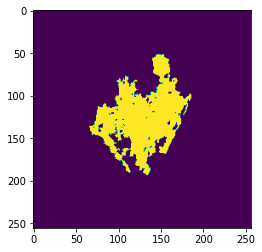

In [3]:
plt.imshow(seg)

In [4]:
print(intersection_over_union_exp(torch.from_numpy(mask),torch.from_numpy(mask)))

tensor(1.)


In [5]:
print(np.unique(seg))

[0 1]


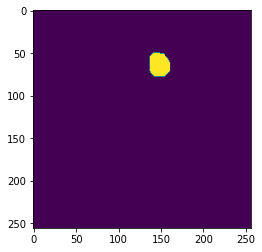

In [6]:
contig = largest_contiguous_region(mask)
plt.imshow(contig)

(256, 256)


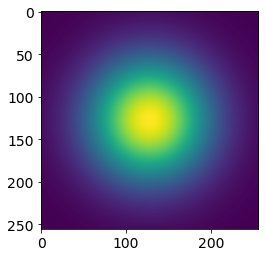

In [26]:
# define normalized 2D gaussian
def gaus2d(x=0, y=0, mx=0, my=0, sx=50, sy=50):
    return 1. / (2. * np.pi * sx * sy) * np.exp(-((x - mx)**2. / (2. * sx**2.) + (y - my)**2. / (2. * sy**2.)))

x = np.linspace(-127, 128,num=256)
y = np.linspace(-127, 128,num=256)
x, y = np.meshgrid(x, y) # get 2D variables instead of 1D
z = gaus2d(x, y)
z = z/np.amax(z)
print(z.shape)
plt.imshow(z)
# unbin_seg = unbinarized_unet_seg.detach().cpu().numpy()
# gaussed = np.multiply(unbin_seg,z)
# plt.imshow(gaussed)

torch.Size([1, 256, 256])
torch.Size([1, 256, 256])


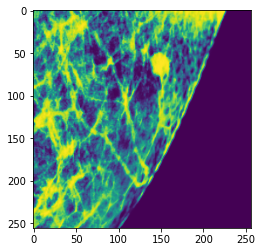

In [35]:
model = torch.load("/usr/xtmp/vs196/mammoproj/Code/ActiveLearning/AllOracleRuns/Run_08_11_1/Iter200/unetmodel.pth")
filepath = "/usr/xtmp/vs196/mammoproj/Data/manualfa/manual_validation/Oval/DP_AASB_7172_1.npy"
filepath = "/usr/xtmp/vs196/mammoproj/Data/manualfa/manual_validation/Oval/DP_ABMJ_14949_1.npy"
arr_and_seg = np.load(filepath)
arr = arr_and_seg[0,:,:]
seg = arr_and_seg[1,:,:]
plt.imshow(arr,cmap="gray")
transforms_arr = [transforms.ToTensor(),transforms.Resize((256,256))]
image_transform = transforms.Compose(transforms_arr)

arr = exposure.equalize_hist(arr) #add hist equalization to
image = image_transform(arr)
print(image.shape)
#image = torch.from_numpy(np.multiply(z,image.numpy()))
print(image.shape)
plt.imshow(image.numpy()[0,:,:])

image = image.float()
image = convert_to_3channel(image).cuda()
image = transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)) (image)

unet_seg = model(image)
unbinarized_unet_seg = F.softmax(unet_seg[0],dim=0)[1,:,:]

tensor(0.)


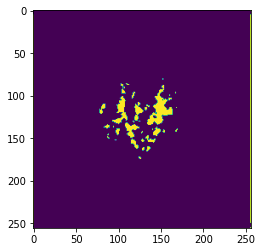

In [33]:
out_seg = unbinarized_unet_seg.detach().cpu().numpy()
out_seg = np.where(out_seg>0.001,1,0)
plt.imshow(out_seg)
mask = image_transform(seg)
print(intersection_over_union_exp(torch.from_numpy(out_seg),mask))

(224, 224)


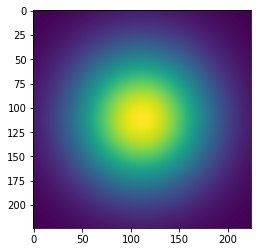

tensor(0.1722)
tensor(0.2932)
tensor(0.1837)
tensor(0.6309)
tensor(0.6063)
tensor(0.5848)
tensor(0.6630)


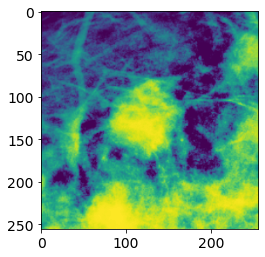

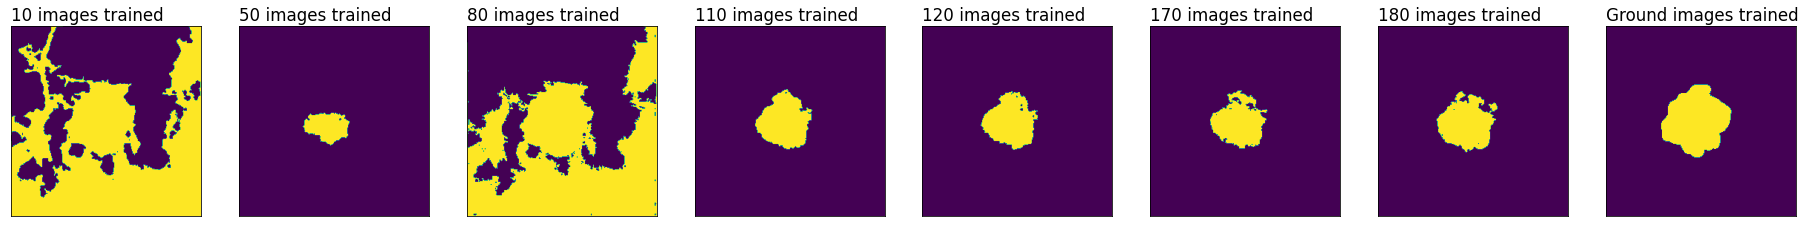

In [41]:

def intersection_over_union(output_mask,ground_mask):
    #ground_mask = get_ints_torch(ground_mask).squeeze(1)
    summed = ground_mask + output_mask
    twos = summed - 2
    num = 256*256 - torch.count_nonzero(twos)
    denom = torch.count_nonzero(summed)
    outputs = torch.div(num,denom)
    return torch.mean(outputs)

def get_binary_mask(mask,threshold):
    return torch.where(mask > threshold, 1, 0)

def get_binary_mask_np(mask):
    return np.where(mask > 0.2, 1, 0)

def get_best_binary_seg(output_seg,ground_image):
    thresholds = [0.0001,0.0005,0.001,0.005,0.01,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4]
    max_iou = 0
    best_seg = None
    for threshold in thresholds:
        bin_output_seg = get_binary_mask(output_seg,threshold)
        bin_output_seg = torch.from_numpy(largest_contiguous_region(bin_output_seg.numpy()))
        #plt.imshow(bin_output_seg)
        #print(torch.count_nonzero(bin_output_seg))
       # sys.exit(1)
        iou = intersection_over_union(bin_output_seg,ground_image)
        if iou>max_iou:
            max_iou = iou
            best_seg = bin_output_seg
    print(max_iou)
    return best_seg


#model dir is /usr/xtmp/vs196/mammoproj/Code/SavedModels/ControlALUNet/0726
def get_models_list(model_dir,images_seen_list):
    models = []
    for size in images_seen_list:
        model_path = model_dir + f"unetmodel_size{size}.pth"
        model = torch.load(model_path)
        models.append(model)
    return models
        

#Code to load in models and output viz
def get_output_from_image(model,image_filepath,ground_image):
    model.eval()
    transforms_arr = [transforms.ToTensor(),transforms.Resize((256,256))]
    image_transform = transforms.Compose(transforms_arr)

    arr_and_bin_output = np.load(image_filepath)

    arr = arr_and_bin_output[0,:,:].copy()
    bin_output = arr_and_bin_output[1,:,:].copy()

    mask = image_transform(bin_output)[0,:,:]
    arr = exposure.equalize_hist(arr) #add hist equalization to 
    image = image_transform(arr)       
    #image = torch.from_numpy(np.multiply(z,image.numpy()))
    plt.imshow(image[0,:,:])
    ground_image = image_transform(ground_image)
    ground_image = get_ints(ground_image)
    
    image = image.float()
    image = convert_to_3channel(image).cuda()
    image = transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)) (image)

    unet_seg = model(image)
    unbinarized_unet_seg = F.softmax(unet_seg[0],dim=0)[1,:,:]
    #unet_seg = get_binary_mask(unbinarized_unet_seg,ground_image).cpu()
    unet_seg = get_best_binary_seg(unbinarized_unet_seg.cpu(),ground_image.cpu())
    return unet_seg

#Model_list where each models_list[i] is the model trained on images_seen_list[i] data points.
#Image_path 
def generate_images_over_time_graph(models_list, images_seen_list, image_path,ground_image_path):
    assert len(images_seen_list)==len(models_list)
    #preprocess image into tensor/resize for input into model
    ground_image = np.load(ground_image_path)[1,:,:]
    outputs = []
    for model in models_list:
        output = get_output_from_image(model,image_path,ground_image)
        outputs.append(output)
    assert len(images_seen_list)==len(outputs)
    return images_seen_list, outputs

images_seen_list = [10,50,80,110,120,170,180]
model_dir = "/usr/xtmp/vs196/mammoproj/Code/SavedModels/ControlALUNet/0726/"
models_list = get_models_list(model_dir,images_seen_list)
image_path = "/usr/xtmp/mammo/image_datasets/data_split_july2021/square_ROI_by_shape_segmentations_unbin/train/Round/DP_AFXS_79651_1.npy"
ground_path = "/usr/xtmp/vs196/mammoproj/Data/manualfa/train/Round/DP_AFXS_79651_1.npy"
images_seen_list,outputs = generate_images_over_time_graph(models_list,images_seen_list,image_path,ground_path)

#DP_ABIF_169241_1
#DP_AECY_37400_1
#DP_AFXS_79651_1.npy
#DP_ACAG_12347_1.npy
images_seen_list.append("Ground")
outputs.append(np.load(ground_path)[1,:,:])
               
#construct the
fig = plt.figure(constrained_layout=False)
num_of_models = len(outputs)
fig.set_size_inches(4*num_of_models, 4)

ncols, nrows = num_of_models, 1
spec = gridspec.GridSpec(ncols=ncols, nrows=nrows, figure=fig)
f_axes = []
for row in range(nrows):
    f_axes.append([])
    for col in range(ncols):
        f_axes[-1].append(fig.add_subplot(spec[row, col]))
        
plt.rcParams.update({'font.size': 14})

for ax_num, ax in enumerate(f_axes[0]):
    ax.set_title(f"{images_seen_list[ax_num]} images trained", fontdict=None, loc='left',color='k')
    
for i,ax in enumerate([f_axes[0][c] for c in range(ncols)]):
    ax.imshow(outputs[i])
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    
plt.show()

tensor(0.7422)
tensor(0.8501)
tensor(0.6909)
tensor(0.7890)
tensor(0.8148)
tensor(0.8319)
tensor(0.8706)


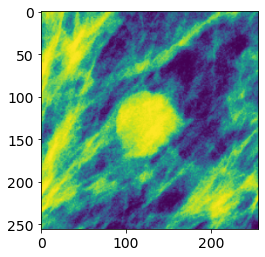

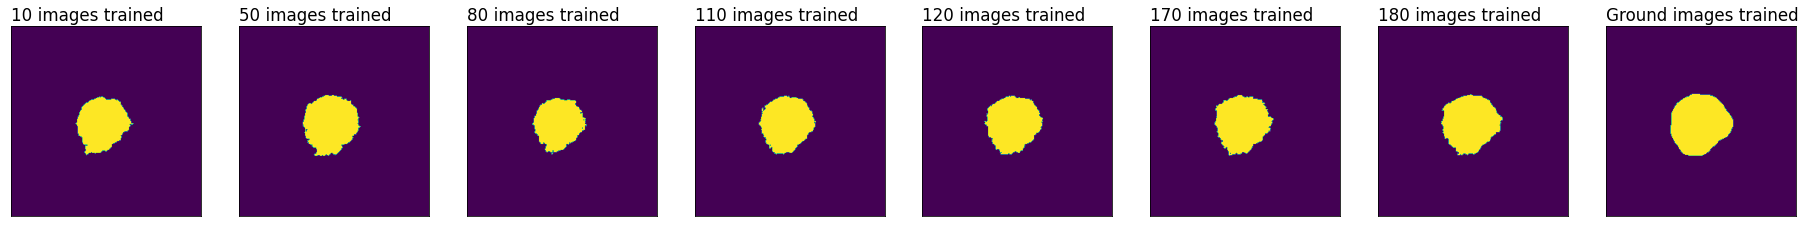

In [42]:
images_seen_list = [10,50,80,110,120,170,180]
model_dir = "/usr/xtmp/vs196/mammoproj/Code/SavedModels/ControlALUNet/0726/"
models_list = get_models_list(model_dir,images_seen_list)
image_path = "/usr/xtmp/mammo/image_datasets/data_split_july2021/square_ROI_by_shape_segmentations_unbin/train/Round/DP_AECY_37400_1.npy"
ground_path = "/usr/xtmp/vs196/mammoproj/Data/manualfa/train/Round/DP_AECY_37400_1.npy"
images_seen_list,outputs = generate_images_over_time_graph(models_list,images_seen_list,image_path,ground_path)

#DP_ABIF_169241_1
#DP_AECY_37400_1
#DP_AFXS_79651_1.npy
#DP_ACAG_12347_1.npy
images_seen_list.append("Ground")
outputs.append(np.load(ground_path)[1,:,:])
               
#construct the
fig = plt.figure(constrained_layout=False)
num_of_models = len(outputs)
fig.set_size_inches(4*num_of_models, 4)

ncols, nrows = num_of_models, 1
spec = gridspec.GridSpec(ncols=ncols, nrows=nrows, figure=fig)
f_axes = []
for row in range(nrows):
    f_axes.append([])
    for col in range(ncols):
        f_axes[-1].append(fig.add_subplot(spec[row, col]))
        
plt.rcParams.update({'font.size': 14})

for ax_num, ax in enumerate(f_axes[0]):
    ax.set_title(f"{images_seen_list[ax_num]} images trained", fontdict=None, loc='left',color='k')
    
for i,ax in enumerate([f_axes[0][c] for c in range(ncols)]):
    ax.imshow(outputs[i])
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    
plt.show()

In [22]:
ground_truth_dir = "/usr/xtmp/vs196/mammoproj/Data/manualfa/train/"
im_dir = "/usr/xtmp/mammo/image_datasets/data_split_july2021/square_ROI_by_shape_segmentations_unbin/train/"
paths = []
for root, dirs, files in os.walk(im_dir):
        for file in files:
            if file.endswith(".npy"):
                paths.append(file)
print(len(paths))

824


In [18]:
554+143 + 169

866

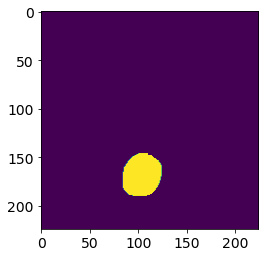

In [34]:
ground_path = "/usr/xtmp/vs196/mammoproj/Data/manualfa/train/Round/DP_ABIF_169241_1.npy"
im = np.load(ground_path)
plt.imshow(im[1,:,:])

In [2]:
import os

oracle_paths = []
manual_paths = []
images_dir = "/usr/xtmp/vs196/mammoproj/Code/ActiveLearning/AllOracleRuns/Run_03_31_a/Iter2/CorrectSegmentations/"
all_images_dir = "/usr/xtmp/mammo/image_datasets/MedStudentSegmentations_dst/"
backup_dir = "/usr/xtmp/vs196/mammoproj/Data/zipped_CorrectSeg_0101b/CorrectSegmentations/"

print("start")
print(images_dir)
for root, dirs, files in os.walk(images_dir):
        for file in files:
            if file.endswith(".npy"):
                oracle_paths.append(file)
                
for root, dirs, files in os.walk(all_images_dir):
    for dir_ in dirs:
        for root1, dirs1, files1 in os.walk(all_images_dir+dir_+"/"):
            for file in files1:
                if file.endswith(".png"):
                    filepath = root1 + file
                    if('b/' not in filepath and '_fa' not in filepath):
                        manual_paths.append(file)
                        
for root,dirs,files in os.walk(backup_dir):
    print(dirs)
    for file in files:
        print(file)
        break
    break
# print(len(oracle_paths))
# print(len(manual_paths))
# print(manual_paths[0])
# print("end")

start
/usr/xtmp/vs196/mammoproj/Code/ActiveLearning/AllOracleRuns/Run_03_31_a/Iter2/CorrectSegmentations/
['Oval', 'Round', 'Irregular', 'zipped_CorrectSeg_0101b', 'saved_data_struct']


In [3]:
intersection = list(set(oracle_paths) & set(manual_paths))
print(intersection) #no common 

[]


In [3]:
#TOTAL OF 871 images present - 839 manually labelled (w/o corrections) and 32 oracle labelled.
backup_oracle_paths = []
oracle_dir = "/usr/xtmp/vs196/mammoproj/Data/zipped_CorrectSeg_0101b/CorrectSegmentations/"
for root,dirs,files in os.walk(oracle_dir):
    for file in files:
        if file.endswith('.npy'):
            backup_oracle_paths.append(file)
print(len(backup_oracle_paths))
print(len(manual_paths))
#TOtal of 1077 images present (839 manual and 238 oracle)

238
839


In [4]:
corrections_dir = "/usr/xtmp/mammo/image_datasets/MedStudentSegmentations_final/"
corrected_filenames = []
corrected_filepaths = []
for root,dirs,files in os.walk(corrections_dir):
    for file in files:
        if '_c' in file:
            filepath = os.path.join(root,file)
            corrected_filenames.append(file)
print(len(corrected_filenames))

319


In [8]:
import csv
#read from Alina CSV: 
#backup_oracle_paths and manual_paths are the 2 files.
i = 0
alina_csv_filepaths = []
counter = dict()
other_csv_path = "/usr/xtmp/vs196/mammoproj/Data/mass_refined_positive_alina.csv"
with open('/usr/xtmp/vs196/mammoproj/Data/mammo_labels.csv') as alina_file:
    csv_reader = csv.reader(alina_file,delimiter=',')
    for line in csv_reader:
        if i==0:
            i += 1
            continue
        filename = line[1].split("/")[-1][:-4]
        if filename in counter:
            counter[filename]+=1
        else:
            counter[filename] = 1
        filename += f"_{counter[filename]}"
        alina_csv_filepaths.append(filename)
print(len(alina_csv_filepaths))

1136


In [20]:
i = 0
counter = dict()
new_csv_filepaths = []
with open(other_csv_path) as alina_file:
    csv_reader = csv.reader(alina_file,delimiter=',')
    for line in csv_reader:
        if i==0:
            i += 1
            continue
        file_info = line[2].split("/")[-1].split("_")
        filename = file_info[0] + "_" + file_info[1] + "_" + file_info[-1][:-4]
        if filename in counter:
            counter[filename]+=1
        else:
            counter[filename] = 1
        filename += f"_{counter[filename]}"
        new_csv_filepaths.append(filename)
print(len(new_csv_filepaths))
print(new_csv_filepaths[0])

1103
DP_ACNW_17340_1


In [32]:
in_csv = []
not_in_csv = []
for file in manual_paths:
    filename = file[:-4]
    if filename in new_csv_filepaths:
        in_csv.append(filename)
    else:
        not_in_csv.append(filename)
print(len(in_csv))
print(len(not_in_csv))
print(not_in_csv[0])

762
77
DP_ACKV_16082_2


In [39]:
print(not_in_csv)

[]


In [33]:
intersection = list(set(backup_oracle_paths) & set(manual_paths))
print(intersection) #no common 

[]


In [30]:
total_paths = []
for i in backup_oracle_paths:
    total_paths.append(i[:-4])
for i in manual_paths:
    total_paths.append(i[:-4])
missing = []
for path in alina_csv_filepaths:
    if path not in total_paths:
        missing.append(path)
print(len(missing))

59


In [27]:
for miss in missing:
    print(miss)

DP_ACYY_22760_1
DP_AAQU_6779_2
DP_ABCT_164330_1
DP_ACPP_17913_1
DP_AFEI_58847_1
DP_AGZJ_114095_1
DP_AFJU_64182_1
DP_AHIQ_122202_1
DP_AMAM_51885_1
DP_AEON_44832_1
DP_AJKG_192266_1
DP_ADQQ_30947_1
DP_AHIQ_122199_1
DP_AEGA_38991_1
DP_AFQA_69893_2
DP_AGXT_113034_1
DP_AEAI_35810_1
DP_AHUJ_131052_1
DP_AHFX_119984_1
DP_AIMN_147951_1
DP_AINE_148601_1
DP_AAYT_160710_1
DP_ADQO_30922_1
DP_ACLU_16346_1
DP_AKEP_3124_1
DP_AFQG_70245_1
DP_AGFV_98140_1
DP_AEDI_37576_1
DP_ADBZ_24030_1
DP_AHSU_130159_1
DP_ADFM_25878_1
DP_AKXF_20408_1
DP_AHCE_116483_1
DP_AFPO_69421_1
DP_ADRF_31277_1
DP_ALUT_44530_1
DP_AFJP_63920_1
DP_ABOZ_176220_1
DP_ABOZ_176220_4
DP_AFKT_65174_1
DP_AFJE_63459_1
DP_AHWL_132694_1
DP_AGMV_104120_1
DP_AEUS_49969_1
DP_AGJJ_100841_1
DP_AKNP_11054_1
DP_AKNP_11055_1
DP_AIDZ_140011_1
DP_AFEA_58448_1
DP_AIVA_156381_1
DP_AHOP_126448_1
DP_AHGU_120736_1
DP_AFGL_60809_1
DP_ACDW_13428_1
DP_ABJK_171167_1
DP_ADTU_32538_1
DP_ADGQ_26325_1
DP_AGMV_104119_1
DP_AEOU_44995_1


In [11]:
#Check validation segs
validation_filepath = "/usr/xtmp/vs196/mammoproj/Data/total_image_dataset/validation/"
validation_filepath = "/usr/xtmp/mammo/image_datasets/data_split_july2021/square_ROI_by_shape_segmentations_unbin/validation/"

images1 = []
for root, dirs, files in os.walk(validation_filepath):
        for file in files:
            if file.endswith(".npy"):
                filepath = os.path.join(root, file)
                images1.append(file)
print(len(images1))

143


In [12]:
#Check validation segs
validation_filepath = "/usr/xtmp/vs196/mammoproj/Data/total_image_dataset/validation/"
#validation_filepath = "/usr/xtmp/mammo/image_datasets/data_split_july2021/square_ROI_by_shape_segmentations_unbin/validation/"

images2 = []
for root, dirs, files in os.walk(validation_filepath):
        for file in files:
            if file.endswith(".npy"):
                filepath = os.path.join(root, file)
                images2.append(file)
print(len(images2))

116


In [25]:
#find extra images in image1 not in image2
extra = []
for image in images1:
    if image not in images2:
        extra.append(image)
        
        
missing_27 = ["DP_ABCT_164330_1.npy",
"DP_AFEI_58847_1.npy",
"DP_AGZJ_114095_1.npy",
"DP_AMAM_51885_1.npy",
"DP_AJKG_192266_1.npy",
"DP_AHIQ_122199_1.npy",
"DP_AEGA_38991_1.npy",
"DP_AFQA_69893_2.npy",
"DP_AIMN_147951_1.npy",
"DP_AINE_148601_1.npy",
"DP_AAYT_160710_1.npy",
"DP_AFQG_70245_1.npy",
"DP_AEDI_37576_1.npy",
"DP_AKXF_20408_1.npy",
"DP_ADRF_31277_1.npy",
"DP_ALUT_44530_1.npy",
"DP_AFKT_65174_1.npy",
"DP_AFJE_63459_1.npy",
"DP_AGMV_104120_1.npy",
"DP_AKNP_11055_1.npy",
"DP_AFEA_58448_1.npy",
"DP_AHOP_126448_1.npy",
"DP_AHGU_120736_1.npy",
"DP_ABJK_171167_1.npy",
"DP_ADTU_32538_1.npy",
"DP_AGMV_104119_1.npy",
"DP_AEOU_44995_1.npy"]

for missing in missing_27:
    print(missing in extra)

for ex in extra:
    print(ex in missing_27)
print(len(extra))
print(extra)

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
27
['DP_AEGA_38991_1.npy', 'DP_AHGU_120736_1.npy', 'DP_AFJE_63459_1.npy', 'DP_AHIQ_122199_1.npy', 'DP_AFKT_65174_1.npy', 'DP_AEOU_44995_1.npy', 'DP_AGMV_104119_1.npy', 'DP_AAYT_160710_1.npy', 'DP_AINE_148601_1.npy', 'DP_AGMV_104120_1.npy', 'DP_AKXF_20408_1.npy', 'DP_AFEA_58448_1.npy', 'DP_AFQG_70245_1.npy', 'DP_ABCT_164330_1.npy', 'DP_AMAM_51885_1.npy', 'DP_ABJK_171167_1.npy', 'DP_AKNP_11055_1.npy', 'DP_AHOP_126448_1.npy', 'DP_AJKG_192266_1.npy', 'DP_AGZJ_114095_1.npy', 'DP_AFEI_58847_1.npy', 'DP_AEDI_37576_1.npy', 'DP_ADTU_32538_1.npy', 'DP_ADRF_31277_1.npy', 'DP_AIMN_147951_1.npy', 'DP_ALUT_44530_1.npy', 'DP_AFQA_69893_2.npy']


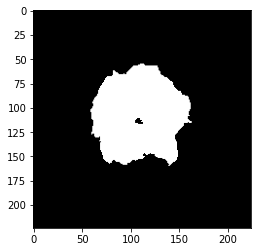

In [46]:
#Code for regenerating segmentations
#Take 1: Just grab segmentation from July split
#Take 2: Run a control UNet on these images to get segmentations
#Take 3: 


filepath = "/usr/xtmp/mammo/image_datasets/data_split_july2021/square_ROI_by_shape_segmentations_unbin/train/Round/DP_ADQQ_30947_1.npy"
image_and_mask = np.load(filepath)
image = image_and_mask[0]
#plt.imshow(image)
mask = largest_contiguous_region(np.where(image_and_mask[1]>0.25,1,0))
plt.imshow(mask,cmap="gray")

In [53]:
#saving 32 in separate directory
filenames = ["DP_ACYY_22760_1.npy",
"DP_AAQU_6779_2.npy",
"DP_ACPP_17913_1.npy",
"DP_AFJU_64182_1.npy",
"DP_AHIQ_122202_1.npy",
"DP_AEON_44832_1.npy",
"DP_ADQQ_30947_1.npy",
"DP_AGXT_113034_1.npy",
"DP_AEAI_35810_1.npy",
"DP_AHUJ_131052_1.npy",
"DP_AHFX_119984_1.npy",
"DP_ADQO_30922_1.npy",
"DP_ACLU_16346_1.npy",
"DP_AKEP_3124_1.npy",
"DP_AGFV_98140_1.npy",
"DP_ADBZ_24030_1.npy",
"DP_AHSU_130159_1.npy",
"DP_ADFM_25878_1.npy",
"DP_AHCE_116483_1.npy",
"DP_AFPO_69421_1.npy",
"DP_AFJP_63920_1.npy",
"DP_ABOZ_176220_1.npy",
"DP_ABOZ_176220_4.npy",
"DP_AHWL_132694_1.npy",
"DP_AEUS_49969_1.npy",
"DP_AGJJ_100841_1.npy",
"DP_AKNP_11054_1.npy",
"DP_AIDZ_140011_1.npy",
"DP_AIVA_156381_1.npy",
"DP_AFGL_60809_1.npy",
"DP_ACDW_13428_1.npy",
"DP_ADGQ_26325_1.npy"]

ops = []
for filename in filenames:
    ops.append(f"cp {filename} /usr/xtmp/vs196/mammoproj/Data/Missing32/;")

all_ops = ""
for op in ops:
    all_ops += op
print(all_ops)
#save these files in /usr/xtmp/vs196/mammoproj/Data/Missing32/


cp DP_ACYY_22760_1.npy /usr/xtmp/vs196/mammoproj/Data/Missing32/;cp DP_AAQU_6779_2.npy /usr/xtmp/vs196/mammoproj/Data/Missing32/;cp DP_ACPP_17913_1.npy /usr/xtmp/vs196/mammoproj/Data/Missing32/;cp DP_AFJU_64182_1.npy /usr/xtmp/vs196/mammoproj/Data/Missing32/;cp DP_AHIQ_122202_1.npy /usr/xtmp/vs196/mammoproj/Data/Missing32/;cp DP_AEON_44832_1.npy /usr/xtmp/vs196/mammoproj/Data/Missing32/;cp DP_ADQQ_30947_1.npy /usr/xtmp/vs196/mammoproj/Data/Missing32/;cp DP_AGXT_113034_1.npy /usr/xtmp/vs196/mammoproj/Data/Missing32/;cp DP_AEAI_35810_1.npy /usr/xtmp/vs196/mammoproj/Data/Missing32/;cp DP_AHUJ_131052_1.npy /usr/xtmp/vs196/mammoproj/Data/Missing32/;cp DP_AHFX_119984_1.npy /usr/xtmp/vs196/mammoproj/Data/Missing32/;cp DP_ADQO_30922_1.npy /usr/xtmp/vs196/mammoproj/Data/Missing32/;cp DP_ACLU_16346_1.npy /usr/xtmp/vs196/mammoproj/Data/Missing32/;cp DP_AKEP_3124_1.npy /usr/xtmp/vs196/mammoproj/Data/Missing32/;cp DP_AGFV_98140_1.npy /usr/xtmp/vs196/mammoproj/Data/Missing32/;cp DP_ADBZ_24030_1.npy 